In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from trl import PPOTrainer

model = AutoModelForCausalLM.from_pretrained("Muennighoff/bloom-tiny-random")
tokenizer = AutoTokenizer.from_pretrained("Muennighoff/bloom-tiny-random")

text = "Hello, how are you?"
input_ids = tokenizer(text, return_tensors='pt').input_ids
output = model(input_ids)
print(output)

2025-06-26 19:39:22.226894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750941562.258453 2555688 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750941562.264866 2555688 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750941562.348582 2555688 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750941562.348610 2555688 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750941562.348611 2555688 computation_placer.cc:177] computation placer alr

CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[ 0.0118, -0.0197,  0.0174,  ...,  0.0388,  0.0666,  0.0774],
         [ 0.0624,  0.0562, -0.0300,  ...,  0.0310,  0.0326, -0.0097],
         [-0.0465,  0.0467,  0.0016,  ..., -0.0033, -0.0165, -0.0509],
         [ 0.0210,  0.0145, -0.0484,  ..., -0.0363, -0.0022, -0.0461],
         [-0.0622,  0.0145, -0.0298,  ..., -0.0633,  0.0226, -0.0194],
         [ 0.0211,  0.0174,  0.0084,  ...,  0.0289,  0.0474,  0.0307]]],
       grad_fn=<UnsafeViewBackward0>), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)


Episode 2/500 | Reward: -5.0 | Avg Reward: 0.0 | Final Pos: 0 | Actor Loss: -0.0115 | Critic Loss: 0.2047 | Entropy: 1.0863
Episode 4/500 | Reward: 7.5 | Avg Reward: 1.2 | Final Pos: 5 | Actor Loss: 0.0016 | Critic Loss: 0.2006 | Entropy: 1.0688
Episode 6/500 | Reward: 17.5 | Avg Reward: 5.8 | Final Pos: 9 | Actor Loss: -0.0048 | Critic Loss: 0.1742 | Entropy: 1.0729
Episode 8/500 | Reward: -2.5 | Avg Reward: 5.3 | Final Pos: 1 | Actor Loss: -0.0072 | Critic Loss: 0.1740 | Entropy: 1.0660
Episode 10/500 | Reward: 5.0 | Avg Reward: 4.8 | Final Pos: 4 | Actor Loss: -0.0164 | Critic Loss: 0.1606 | Entropy: 1.0399
Episode 12/500 | Reward: 30.0 | Avg Reward: 9.0 | Final Pos: 10 | Actor Loss: -0.0012 | Critic Loss: 0.1313 | Entropy: 0.9973
Episode 14/500 | Reward: 10.0 | Avg Reward: 9.5 | Final Pos: 6 | Actor Loss: -0.0096 | Critic Loss: 0.1287 | Entropy: 0.9599
Episode 16/500 | Reward: 30.0 | Avg Reward: 10.9 | Final Pos: 10 | Actor Loss: -0.0043 | Critic Loss: 0.0787 | Entropy: 0.8999
Epis

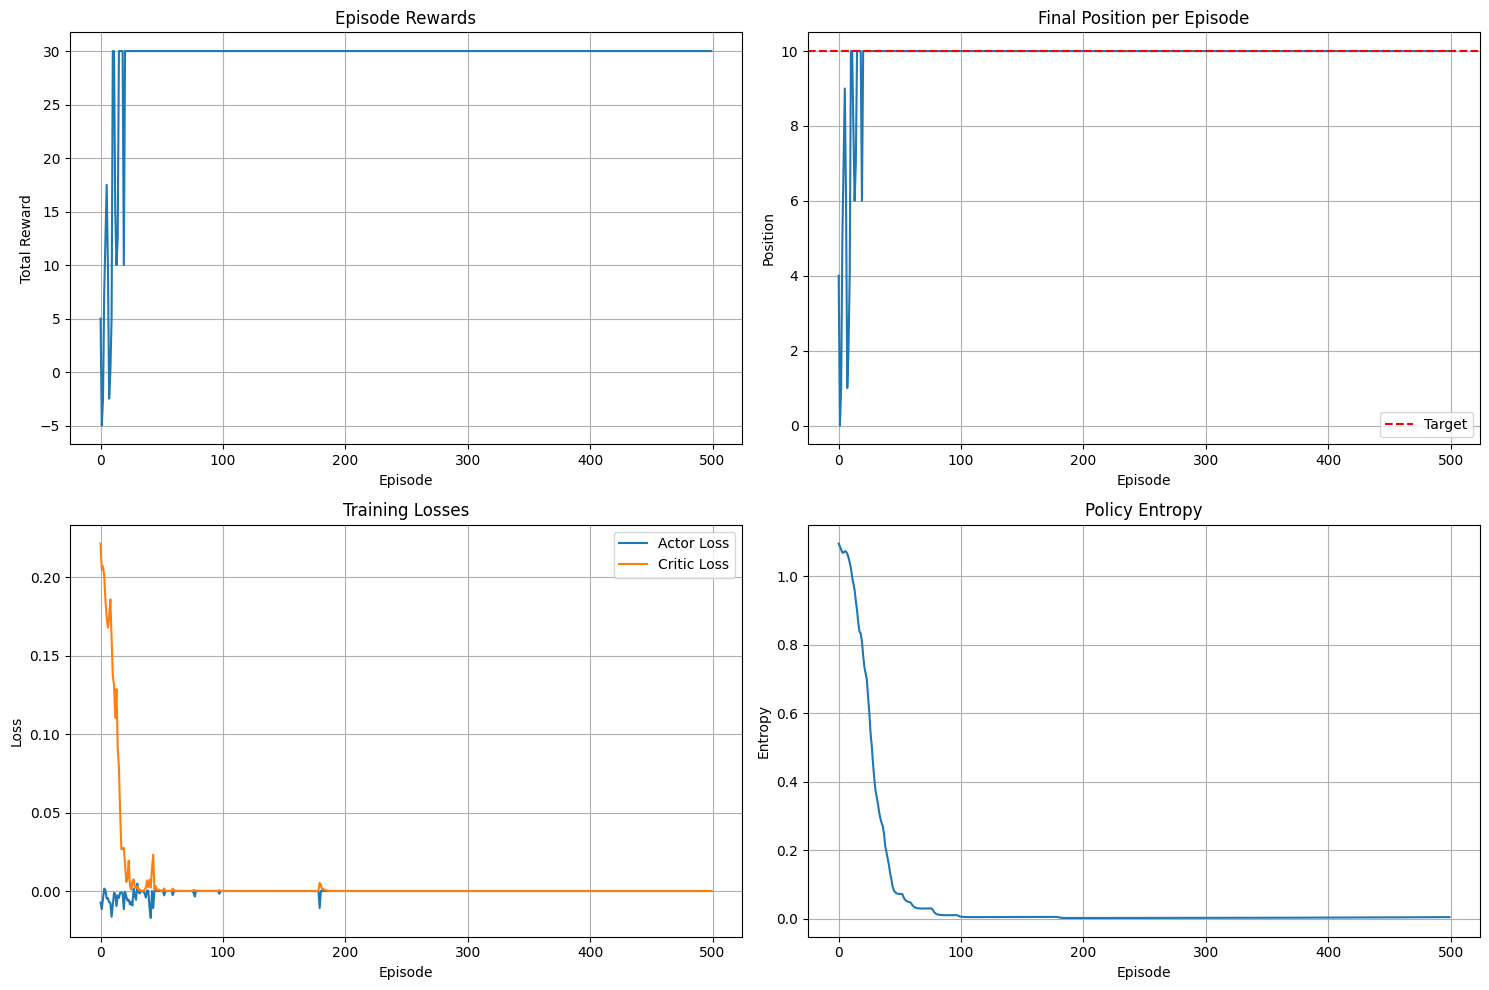

Test 1: Final position = 10, Steps = 10
Test 2: Final position = 10, Steps = 10
Test 3: Final position = 10, Steps = 10
Test 4: Final position = 10, Steps = 10
Test 5: Final position = 10, Steps = 10


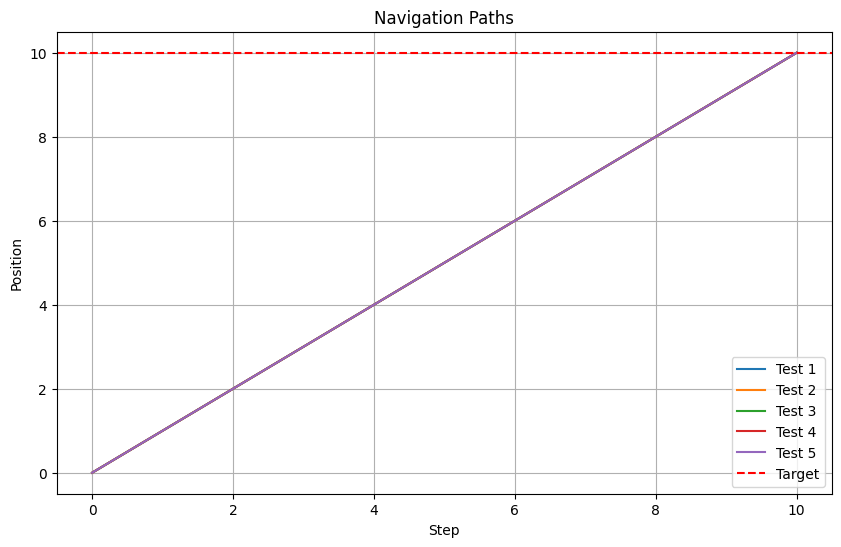

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

# Thiết lập seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ======================
# MÔI TRƯỜNG DI CHUYỂN 1D (ĐÃ SỬA)
# ======================
class NavigationEnv:
    def __init__(self):
        self.start_pos = 0
        self.target_pos = 10
        self.max_steps = 20  # Giảm số bước tối đa
        self.reset()
        
    def reset(self):
        self.current_pos = self.start_pos
        self.steps = 0
        self.done = False
        return self.get_state()
    
    def get_state(self):
        # State: [vị trí hiện tại, khoảng cách tới đích] - chuẩn hóa
        return np.array([self.current_pos / 10.0, (self.target_pos - self.current_pos) / 10.0], dtype=np.float32)
    
    def step(self, action):
        """Di chuyển theo action và trả về next_state, reward, done"""
        self.steps += 1
        old_pos = self.current_pos
        
        # Action: 0 = trái, 1 = giữ nguyên, 2 = phải
        if action == 0:
            self.current_pos = max(0, self.current_pos - 1)
        elif action == 2:
            self.current_pos = min(20, self.current_pos + 1)  # Giới hạn tối đa
            
        # Tính khoảng cách mới
        new_dist = abs(self.target_pos - self.current_pos)
        old_dist = abs(self.target_pos - old_pos)
        
        # Reward chính: giảm khoảng cách
        reward = (old_dist - new_dist) * 2.0
        
        # Thưởng khi đến đích
        if self.current_pos == self.target_pos:
            reward += 10.0  # Thưởng đạt mục tiêu
            self.done = True
        
        # Phạt nếu vượt quá số bước
        if self.steps >= self.max_steps and not self.done:
            self.done = True
            # Phạt nhiều hơn nếu xa mục tiêu
            reward -= new_dist * 0.5
        
        return self.get_state(), reward, self.done

# ======================
# MẠNG NEURAL ACTOR-CRITIC (ĐÃ SỬA)
# ======================
class ActorCritic(nn.Module):
    def __init__(self, input_size, output_size):
        super(ActorCritic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),  # Tăng số neuron
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.actor = nn.Linear(128, output_size)
        self.critic = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.fc(x)
        action_logits = self.actor(x)
        state_value = self.critic(x)
        return action_logits, state_value

# ======================
# THUẬT TOÁN PPO (ĐÃ SỬA)
# ======================
class PPO:
    def __init__(self, env, policy, lr=1e-3, gamma=0.99, epsilon=0.2, entropy_coef=0.01):
        self.env = env
        self.policy = policy
        self.optimizer = optim.Adam(policy.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.entropy_coef = entropy_coef
        
        # Bộ nhớ
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.log_probs = []
        self.values = []
        
    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_logits, value = self.policy(state_tensor)
        action_probs = torch.softmax(action_logits, dim=-1)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob.item(), value.item()
    
    def store_transition(self, state, action, log_prob, value, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def compute_returns(self):
        returns = []
        R = 0
        for reward, done in zip(reversed(self.rewards), reversed(self.dones)):
            if done:
                R = 0
            R = reward + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)  # Chuẩn hóa returns
        return returns
    
    def update(self):
        # Tính returns
        returns = self.compute_returns()
        
        # Chuyển dữ liệu sang tensor
        states = torch.tensor(self.states, dtype=torch.float32)
        actions = torch.tensor(self.actions, dtype=torch.long)
        old_log_probs = torch.tensor(self.log_probs, dtype=torch.float32)
        old_values = torch.tensor(self.values, dtype=torch.float32)
        
        # Tính advantage
        advantages = returns - old_values
        
        # Chuẩn hóa advantage
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Tối ưu trong nhiều epoch
        actor_losses = []
        critic_losses = []
        entropy_losses = []
        
        for _ in range(4):  # 4 epoch update
            # Lấy dữ liệu mới
            action_logits, values = self.policy(states)
            action_probs = torch.softmax(action_logits, dim=-1)
            dist = torch.distributions.Categorical(action_probs)
            
            # Tính entropy
            entropy = dist.entropy().mean()
            
            # Tính log prob mới
            new_log_probs = dist.log_prob(actions)
            
            # Tính ratio
            ratio = torch.exp(new_log_probs - old_log_probs)
            
            # PPO loss
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            # Critic loss (Huber loss ổn định hơn MSE)
            critic_loss = 0.5 * nn.SmoothL1Loss()(values.squeeze(), returns)
            
            # Tổng loss
            loss = actor_loss + critic_loss - self.entropy_coef * entropy
            
            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
            
            # Lưu losses
            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())
            entropy_losses.append(entropy.item())
        
        # Xóa bộ nhớ
        self.clear_memory()
        
        return np.mean(actor_losses), np.mean(critic_losses), np.mean(entropy_losses)
    
    def clear_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.log_probs = []
        self.values = []

# ======================
# HÀM HUẤN LUYỆN (ĐÃ SỬA)
# ======================
def train_ppo(env, num_episodes=1000):
    input_size = 2
    output_size = 3
    
    # Tạo model và agent
    model = ActorCritic(input_size, output_size)
    agent = PPO(env, model, lr=5e-4)  # Learning rate nhỏ hơn
    
    # Theo dõi kết quả
    episode_rewards = []
    actor_losses = []
    critic_losses = []
    entropy_losses = []
    positions = []
    
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        ep_positions = [env.current_pos]
        
        while not done:
            # Chọn hành động
            action, log_prob, value = agent.select_action(state)
            
            # Thực hiện hành động
            next_state, reward, done = env.step(action)
            
            # Lưu transition
            agent.store_transition(state, action, log_prob, value, reward, done)
            
            # Cập nhật
            state = next_state
            total_reward += reward
            ep_positions.append(env.current_pos)
            
        # Cập nhật policy sau mỗi episode
        if len(agent.rewards) > 0:
            actor_loss, critic_loss, entropy_loss = agent.update()
            
            # Lưu kết quả
            episode_rewards.append(total_reward)
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
            entropy_losses.append(entropy_loss)
            positions.append(ep_positions)
            
            if (episode + 1) % 2 == 0:
                avg_reward = np.mean(episode_rewards[-50:])
                print(f'Episode {episode+1}/{num_episodes} | '
                      f'Reward: {total_reward:.1f} | '
                      f'Avg Reward: {avg_reward:.1f} | '
                      f'Final Pos: {env.current_pos} | '
                      f'Actor Loss: {actor_loss:.4f} | '
                      f'Critic Loss: {critic_loss:.4f} | '
                      f'Entropy: {entropy_loss:.4f}')
    
    return {
        'rewards': episode_rewards,
        'actor_losses': actor_losses,
        'critic_losses': critic_losses,
        'entropy_losses': entropy_losses,
        'positions': positions,
        'model': model
    }

# ======================
# CHẠY HUẤN LUYỆN
# ======================
env = NavigationEnv()
results = train_ppo(env, num_episodes=500)
model = results['model']

# ======================
# VẼ BIỂU ĐỒ KẾT QUẢ
# ======================
plt.figure(figsize=(15, 10))

# Biểu đồ reward
plt.subplot(2, 2, 1)
plt.plot(results['rewards'])
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

# Biểu đồ vị trí cuối mỗi episode
plt.subplot(2, 2, 2)
final_positions = [pos[-1] for pos in results['positions']]
plt.plot(final_positions)
plt.axhline(y=10, color='r', linestyle='--', label='Target')
plt.title('Final Position per Episode')
plt.xlabel('Episode')
plt.ylabel('Position')
plt.legend()
plt.grid(True)

# Biểu đồ loss
plt.subplot(2, 2, 3)
plt.plot(results['actor_losses'], label='Actor Loss')
plt.plot(results['critic_losses'], label='Critic Loss')
plt.title('Training Losses')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Biểu đồ entropy
plt.subplot(2, 2, 4)
plt.plot(results['entropy_losses'])
plt.title('Policy Entropy')
plt.xlabel('Episode')
plt.ylabel('Entropy')
plt.grid(True)

plt.tight_layout()
plt.savefig('ppo_navigation_results.png')
plt.show()

# ======================
# KIỂM TRA MODEL
# ======================
def test_model(env, model, num_tests=5):
    plt.figure(figsize=(10, 6))
    for test in range(num_tests):
        state = env.reset()
        done = False
        positions = [env.current_pos]
        
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_logits, _ = model(state_tensor)
            action_probs = torch.softmax(action_logits, dim=-1)
            action = torch.argmax(action_probs).item()
            
            state, _, done = env.step(action)
            positions.append(env.current_pos)
        
        plt.plot(positions, label=f'Test {test+1}')
        print(f"Test {test+1}: Final position = {env.current_pos}, Steps = {len(positions)-1}")
    
    plt.axhline(y=env.target_pos, color='r', linestyle='--', label='Target')
    plt.title('Navigation Paths')
    plt.xlabel('Step')
    plt.ylabel('Position')
    plt.legend()
    plt.grid(True)
    plt.savefig('ppo_navigation_test.png')
    plt.show()

test_model(NavigationEnv(), model)

$\mathcal{L} = - \sum_{j=1}^M \sum_{k=1}^{K_j} \left( \frac{\pi_{\theta}(a_{jk} | s_j)}{\pi_{\theta_{\text{old}}}(a_{jk} | s_j)} A_{jk} \right) + \beta \sum_{j=1}^M \text{KL}(\pi_{\theta}( \cdot | s_j) || \pi_{\theta_{\text{old}}}( \cdot | s_j))$

In [2]:
# train_game7_verl.py

import random
import numpy as np
from typing import Tuple, Any, Dict

from verl.envs.base import Environment
from verl.trainer import PPOTrainer
from verl.agents.huggingface_agent import HuggingFaceAgent


class Game7Env(Environment):
    def __init__(self, seed: int = None):
        super().__init__()
        self.seed(seed)
        self.action_space = {
            'type': 'discrete',
            'n': 3,
            'description': ['Add 1', 'Add 2', 'Add 3']
        }
        self.observation_space = {
            'type': 'discrete',
            'n': 7,
            'shape': (7,),
            'dtype': np.float32
        }
        self.max_steps = 20
        self.reset()

    def seed(self, seed: int = None) -> None:
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

    def _format_state_message(self) -> str:
        return f"Current total: {self.current}/7. Your turn. Choose 1, 2, or 3 to add."

    def reset(self) -> str:
        self.current = 0
        self.done = False
        self.current_step = 0
        return self._format_state_message()

    def step(self, action: Any) -> Tuple[str, float, bool, Dict[str, Any]]:
        if self.done:
            raise ValueError("Episode has ended. Call reset() to start a new episode.")
        if self.current_step >= self.max_steps:
            self.done = True
            return self._format_state_message(), -10, self.done, {'reason': 'max_steps_reached'}
        try:
            action = int(action)
            if action not in [0, 1, 2]:
                return self._format_state_message(), -100, True, {'reason': 'invalid_action'}
        except (ValueError, TypeError):
            return self._format_state_message(), -100, True, {'reason': 'invalid_action'}
        player_move = action + 1
        self.current += player_move
        info = {
            'player_move': player_move,
            'current_sum': self.current,
            'step': self.current_step
        }
        if self.current > 7:
            self.done = True
            return self._format_state_message(), -100, self.done, {**info, 'reason': 'player_bust'}
        if self.current == 7:
            self.done = True
            return self._format_state_message(), 100, self.done, {**info, 'reason': 'player_win'}
        opponent_move = random.randint(1, 3)
        self.current += opponent_move
        info['opponent_move'] = opponent_move
        info['current_sum_after_opponent'] = self.current
        if self.current > 7:
            reward = 100
            self.done = True
            info['reason'] = 'opponent_bust'
        elif self.current == 7:
            reward = -100
            self.done = True
            info['reason'] = 'opponent_win'
        else:
            reward = 1
            self.done = False
            info['reason'] = 'continue'
        self.current_step += 1
        return self._format_state_message(), reward, self.done, info


def main():
    # Create environment
    env = Game7Env()

    # Create agent (LLM backbone, you can choose any GPT model)
    agent = HuggingFaceAgent(
        model_name="gpt2",  # You can use mistral, phi-2, or any local LLM
        max_new_tokens=5,
        stop_sequences=["\n"]
    )

    # Create trainer (PPO)
    trainer = PPOTrainer(
        agent=agent,
        env=env,
        total_steps=10000,  # Total env steps
        rollout_batch_size=16,
        update_epochs=4,
        minibatch_size=8,
        learning_rate=1e-5,
        kl_coef=0.1,
        log_dir="./logs/game7"
    )

    # Start training
    trainer.train()


if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'verl.envs'